In [ ]:
#pip install opencv-python

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
    --------------------------------------- 0.5/39.0 MB 2.8 MB/s eta 0:00:14
   - -------------------------------------- 1.8/39.0 MB 4.8 MB/s eta 0:00:08
   -- ------------------------------------- 2.6/39.0 MB 4.7 MB/s eta 0:00:08
   --- ------------------------------------ 3.4/39.0 MB 4.9 MB/s eta 0:00:08
   ---- ----------------------------------- 4.2/39.0 MB 4.5 MB/s eta 0:00:08
   ----- ---------------------------------- 5.2/39.0 MB 4.5 MB/s eta 0:00:08
   ------ --------------------------------- 6.3/39.0 MB 4.4 MB/s eta 0:00:08
   ------- -------------------------------- 7.6/39.0 MB 4.7 MB/s eta 0:00:07
   -------- ------------------------------- 8.7/39.0 MB 4.8 MB/s eta 0:00:07
   ---------- ----------------------------- 10.0/39.0 MB 4.8 MB/s eta 0:00:06
   ----------- ---------------------------- 11.3/39.0 MB 5.0 MB/s eta 0:00:06
   --------

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Users\\Maram\\anaconda3\\envs\\myevn\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [7]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
from datetime import datetime
from IPython.display import display, clear_output
import ipywidgets as widgets

# Load the trained model
def load_coal_model(model_path, device):
    """
    Load the trained coal quality detection model
    """
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(256, 2)  # 2 classes: Defect_coal and Good_quality_coal
    )
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    return model

# Define image transformations
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class_names = ['Defect_coal', 'Good_quality_coal']

def predict_coal_quality(image, model, device):
    """
    Predict coal quality from image
    """
    image_tensor = data_transforms(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item()
    
    return predicted_class, confidence_score, probabilities.cpu().numpy()[0]


Coal Quality Detection System - Jupyter Version
1. Interactive camera detection (Manual capture)
2. Automatic camera detection (Continuous analysis)
3. Test with saved image


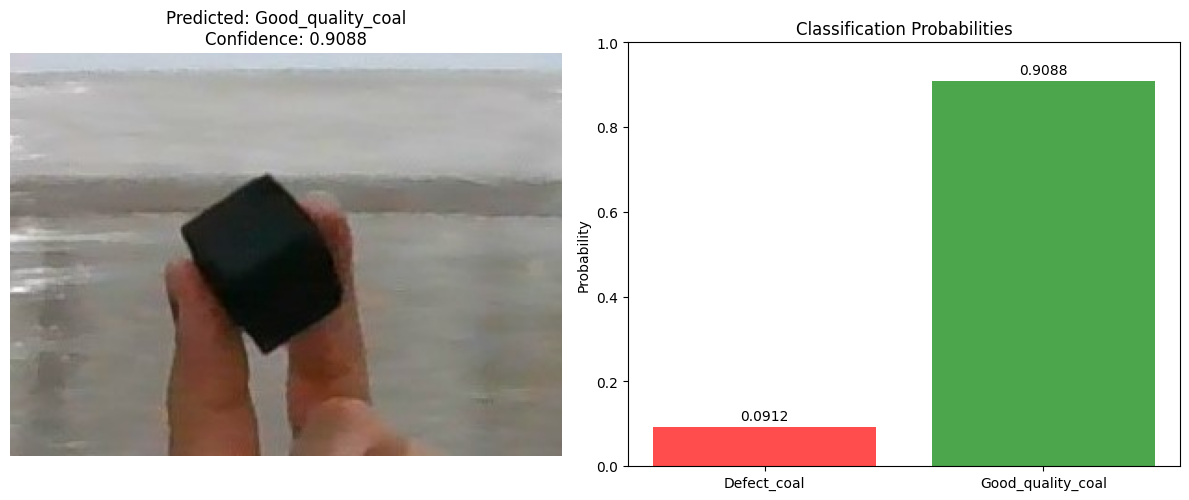


Analysis Results for E:\AI Deep learning\coal_project\project2_largdata_coal\livepic.jpg:
Predicted Class: Good_quality_coal
Confidence: 0.9088
Defect_coal: 0.0912
Good_quality_coal: 0.9088


In [10]:

# Jupyter-compatible camera detection
def coal_quality_camera_detection_jupyter(model_path='coal_quality_model.pth'):
    """
    Jupyter-compatible version for coal quality detection
    """
    if not os.path.exists(model_path):
        print(f"Error: Model file '{model_path}' not found!")
        return
    
    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load model
    print("Loading coal quality detection model...")
    model = load_coal_model(model_path, device)
    print("Model loaded successfully!")
    
    # Initialize camera
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Could not open camera!")
        return
    
    print("\nCamera Controls:")
    print("- The camera feed will show below")
    print("- Press 'c' in the input box to capture and analyze")
    print("- Press 'q' to quit")
    
    # Create output directory
    output_dir = "coal_detection_results"
    os.makedirs(output_dir, exist_ok=True)
    
    captured_frame = None
    analysis_results = None
    saved_images_count = 0
    
    # Create figure for display
    plt.ion()  # Turn on interactive mode
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture image")
                break
            
            # Convert BGR to RGB for matplotlib
            display_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Clear previous plots
            ax1.clear()
            ax2.clear()
            
            if captured_frame is not None:
                # Display live feed and captured image side by side
                ax1.imshow(display_frame)
                ax1.set_title('Live Camera Feed', fontsize=12, fontweight='bold')
                ax1.axis('off')
                
                captured_rgb = cv2.cvtColor(captured_frame, cv2.COLOR_BGR2RGB)
                ax2.imshow(captured_rgb)
                
                if analysis_results:
                    predicted_class, confidence, probabilities = analysis_results
                    color = 'green' if predicted_class == 'Good_quality_coal' else 'red'
                    ax2.set_title(f'Captured Image\n{predicted_class} (Confidence: {confidence:.2f})', 
                                fontsize=12, fontweight='bold', color=color)
                else:
                    ax2.set_title('Captured Image (Ready for Analysis)', fontsize=12, fontweight='bold')
                ax2.axis('off')
                
            else:
                # Display only live feed
                ax1.imshow(display_frame)
                ax1.set_title('Live Camera Feed - Press "c" to capture', fontsize=12, fontweight='bold')
                ax1.axis('off')
                ax2.text(0.5, 0.5, 'No image captured\nPress "c" to capture frame', 
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax2.transAxes, fontsize=14)
                ax2.set_title('Captured Image', fontsize=12, fontweight='bold')
                ax2.axis('off')
            
            plt.tight_layout()
            plt.draw()
            plt.pause(0.01)
            
            # Get user input
            user_input = input("Press 'c' to capture, 's' to save, 'r' to reset, 'q' to quit: ").strip().lower()
            
            if user_input == 'q':
                break
            elif user_input == 'c':
                captured_frame = frame.copy()
                
                # Convert captured frame to PIL Image
                pil_image = Image.fromarray(cv2.cvtColor(captured_frame, cv2.COLOR_BGR2RGB))
                
                # Analyze the image
                predicted_class, confidence, probabilities = predict_coal_quality(pil_image, model, device)
                analysis_results = (predicted_class, confidence, probabilities)
                
                print(f"\nAnalysis Results:")
                print(f"Predicted Class: {predicted_class}")
                print(f"Confidence: {confidence:.4f}")
                for class_name, prob in zip(class_names, probabilities):
                    print(f"{class_name}: {prob:.4f}")
                    
            elif user_input == 's' and captured_frame is not None:
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = f"{output_dir}/coal_{timestamp}_{saved_images_count}.jpg"
                cv2.imwrite(filename, captured_frame)
                saved_images_count += 1
                print(f"Image saved as: {filename}")
                
            elif user_input == 'r':
                captured_frame = None
                analysis_results = None
                print("Analysis reset. Ready for new capture.")
                
    except KeyboardInterrupt:
        print("\nInterrupted by user")
    finally:
        # Cleanup
        cap.release()
        plt.ioff()
        plt.close()
        print(f"\nCamera session ended. Saved images: {saved_images_count}")

# Simple version with automatic capture
def simple_coal_detection_jupyter(model_path='coal_quality_model.pth', capture_interval=5):
    """
    Simple version that automatically captures and analyzes every few seconds
    """
    if not os.path.exists(model_path):
        print(f"Error: Model file '{model_path}' not found!")
        return
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = load_coal_model(model_path, device)
    
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Could not open camera!")
        return
    
    print(f"Automatic detection started. Capturing every {capture_interval} seconds.")
    print("Press Ctrl+C to stop.")
    
    plt.ion()
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Convert for display
            display_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Analyze current frame
            pil_image = Image.fromarray(display_frame)
            predicted_class, confidence, probabilities = predict_coal_quality(pil_image, model, device)
            
            # Display results
            ax.clear()
            ax.imshow(display_frame)
            
            color = 'green' if predicted_class == 'Good_quality_coal' else 'red'
            ax.set_title(f'Coal Quality: {predicted_class}\nConfidence: {confidence:.2f}', 
                        fontsize=14, fontweight='bold', color=color)
            ax.axis('off')
            
            # Add probability information
            prob_text = '\n'.join([f'{name}: {prob:.2f}' for name, prob in zip(class_names, probabilities)])
            ax.text(0.02, 0.98, prob_text, transform=ax.transAxes, fontsize=12,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            plt.tight_layout()
            plt.draw()
            plt.pause(capture_interval)
            
    except KeyboardInterrupt:
        print("\nStopped by user")
    finally:
        cap.release()
        plt.ioff()
        plt.close()

# Test with saved image (unchanged)
def test_with_saved_image(image_path, model_path='coal_quality_model.pth'):
    """
    Test the model with a saved image file
    """
    if not os.path.exists(model_path):
        print(f"Error: Model file '{model_path}' not found!")
        return
    
    if not os.path.exists(image_path):
        print(f"Error: Image file '{image_path}' not found!")
        return
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = load_coal_model(model_path, device)
    
    # Load and analyze image
    pil_image = Image.open(image_path).convert('RGB')
    predicted_class, confidence, probabilities = predict_coal_quality(pil_image, model, device)
    
    # Display results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(pil_image)
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.4f}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    colors = ['red' if name == 'Defect_coal' else 'green' for name in class_names]
    bars = plt.bar(class_names, probabilities, color=colors, alpha=0.7)
    plt.title('Classification Probabilities')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bar, prob in zip(bars, probabilities):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{prob:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nAnalysis Results for {image_path}:")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")
    for class_name, prob in zip(class_names, probabilities):
        print(f"{class_name}: {prob:.4f}")

# Widget-based version (alternative)
def create_camera_widget():
    """Create a widget-based camera interface"""
    import ipywidgets as widgets
    from IPython.display import display
    
    # Create widgets
    capture_btn = widgets.Button(description="Capture & Analyze")
    save_btn = widgets.Button(description="Save Image")
    reset_btn = widgets.Button(description="Reset")
    quit_btn = widgets.Button(description="Quit")
    
    output = widgets.Output()
    
    # Display widgets
    display(widgets.HBox([capture_btn, save_btn, reset_btn, quit_btn]))
    display(output)
    
    return capture_btn, save_btn, reset_btn, quit_btn, output

if __name__ == "__main__":
    print("Coal Quality Detection System - Jupyter Version")
    print("=" * 50)
    print("1. Interactive camera detection (Manual capture)")
    print("2. Automatic camera detection (Continuous analysis)")
    print("3. Test with saved image")
    
    choice = input("\nSelect mode (1/2/3): ").strip()
    
    if choice == '1':
        coal_quality_camera_detection_jupyter()
    elif choice == '2':

        
        interval = input("Enter capture interval in seconds (default: 5): ").strip()
        try:
            interval = float(interval) if interval else 5
        except:
            interval = 5
        simple_coal_detection_jupyter(capture_interval=interval)
    elif choice == '3':
        image_path = input("Enter image path: ").strip()
        test_with_saved_image(image_path)
    else:
        print("Invalid choice!")